In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from pandas.plotting import scatter_matrix


I want to generate 1 liner methods to try different distributions for data. The core idea is 
1)Generate variable in related set
a1 is correlated with a2
b1 is correlated with b2

For every set , i define a function to generate y (target variable)


In [0]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

def poly_model(datas,actuals):
  a = PolynomialFeatures(2)
  
  #print(a.fit_transform(datas).astype(int))
  modelo = make_pipeline(a, LinearRegression())
  modelo.fit(datas, actuals)
  
  predicts = modelo.predict(datas)
  return (predicts,modelo)

def plot_model(datas,actuals,predicts):
  fig = pyplot.figure()
  ax = Axes3D(fig)
  #XT = datas.transpose()
  x_vals = datas[0]
  y_vals = datas[1]
  z_vals = actuals
  #print("x_vals",x_vals.shape)
  #print("y_vals",y_vals.shape)
  #print("z_vals",z_vals.shape)
  
  
  ax.scatter(x_vals, y_vals, z_vals, color='red')
  ax.scatter(x_vals, y_vals, predicts, color='blue')
  
  
def f_x12_x21(x):
  #print(x[0],x[1])
  return (x[0]**2+10*x[1] ) * np.random.randint(70,130, size=1)[0] / 100

def gen_data(x,func):
  func_applied = np.apply_along_axis(func, 1, x)
  return func_applied

def calculate_mse(actuals,predicts):
  mse = sum((actuals-predicts)**2) / len(actuals)
  return mse

class TestStats:
  pass

precision = "{0:.8f}"

make0 = lambda x: 0 if x == 0 else x
make0func = np.vectorize(make0)

def linear_regression(data,actuals):
  linreg = LinearRegression(normalize=True)
  linreg.fit(data,actuals)
  y_pred = linreg.predict(data)
  
  stats = TestStats()
  stats.name = "Linear -"
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = linreg
  stats.coeffs = np.array([ precision.format(  xi ) for xi in linreg.coef_]) 
  stats.intercept = linreg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(linreg.coef_  == 0)
  stats.zero_params =  ', '.join( data.columns[ np.where( linreg.coef_ == 0) ] )
  
  calculate_stats(stats)
  return stats


def ridge_regression(data,actuals,alpha):
   
  
  ridgereg = Ridge(alpha=alpha,normalize=True)
  ridgereg.fit(data, actuals)
  y_pred = ridgereg.predict(data)
  
  stats = TestStats()
  stats.name = "Ridge -"+str(alpha  )
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = ridgereg
  stats.coeffs = np.array([ precision.format(  xi ) for xi in ridgereg.coef_]) 
  stats.intercept = ridgereg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(ridgereg.coef_  == 0)
  stats.zero_params = ', '.join( data.columns[ np.where( ridgereg.coef_ == 0) ] )

  
  calculate_stats(stats)
  return stats


def lasso_regression(data,actuals,alpha,fit_intercept ):
  
  
  
  lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5,fit_intercept=fit_intercept)
  lassoreg.fit(data,actuals)
  y_pred = lassoreg.predict(data)
  
  stats = TestStats()
  stats.name = "Lasso -"+str(alpha) +"|"+str( fit_intercept)
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = lassoreg
  stats.coeffs =  make0func( np.array([ precision.format(  xi ) for xi in lassoreg.coef_]) )
  stats.intercept = lassoreg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(lassoreg.coef_  == 0)
  stats.zero_params = ', '.join( data.columns[ np.where( lassoreg.coef_ == 0) ] )
  
  calculate_stats(stats)
  return stats


    

def calculate_stats(stats):
  stats.mse = precision.format( calculate_mse(stats.actuals,stats.predictions) )
  stats.r2_score = r2_score(stats.actuals,stats.predictions)
  stats.mean_squared_error = precision.format( mean_squared_error(stats.actuals,stats.predictions))
  
  
  
def dump_stats(stats): 
  print("r2_score",stats.r2_score)
  print("mean_squared_error",stats.mean_squared_error)  
  print("coeffs",stats.coeffs)  
  print("mse", stats.mse)
  
  
def plot_from_stats(stats):
  plot_model(stats.data.transpose(),stats.actuals.transpose(),stats.predictions)
  
  

def append_df(df,stat_instances,col_name):
  vals = []  
  for stat in stat_instances:  
    vals.append(getattr(stat, col_name))
  df[col_name] = vals  
  
def get_attributes(stats,field):
  vals = []
  for stat in stats:
    vals.append(getattr(stat, field))
  return vals  

def get_multi_attributes(stats,field,index):
  vals = []
  for stat in stats:
    vals.append(getattr(stat, field)[index])
  return vals    

Define different combination of parameters for Lasso,Ridge,Linear regression

In [0]:
def test_batch(dataset):
  alphas = [ 1e-10,  1e-4, 1e-3,1e-2, 1, 5]
  parameter_columns = dataset.columns.drop("y")
  data = dataset[parameter_columns]
  
  actuals = dataset['y']
  stats = []
  for alpha in alphas :
    stats_lasso = lasso_regression(data,actuals,alpha,False) 
    stats.append(stats_lasso)
  
  for alpha in alphas :
    stats_lasso = lasso_regression(data,actuals,alpha,True) 
    stats.append(stats_lasso)  

  for alpha in alphas :
    stats_ridge = ridge_regression(data,actuals,alpha) 
    stats.append(stats_ridge)
  
  stats_linear = linear_regression(data,actuals) 
  stats.append(stats_linear)

  pd_stats = pd.DataFrame()
  pd_columns = ["name","mse","mean_squared_error","r2_score","intercept","coeffs_zero","zero_params"]
  for column in pd_columns :
    pd_stats[column] = get_attributes(stats,column)

  for index,column in  enumerate(parameter_columns):
    pd_stats[column] = get_multi_attributes(stats,"coeffs",index)  
    
    
  
  scatter_matrix(dataset, figsize=(8, 8))
  plt.show()  
  
  return pd_stats  #.sort_values(by=['r2_score'] , ascending=False)

Generate random variables. A's and B's are correlated.

In [0]:
def gen_dataset(dim):
  a1 = np.random.randint(0, 50, dim)
  a2 = a1 +  np.random.randint(0, 10, dim)
  b1=  np.random.randint(0, 50, dim)
  b2=  b1 * np.random.randint(0, 10, dim)    
  c1 = np.random.randint(0,100,dim)  
  data = pd.DataFrame(np.column_stack([a1,a2,b1,b2,c1]),columns=['a1','a2','b1','b2','c1'])
  return data

def gen_dataset2(dim):
  a1 = np.random.randint(0, 50, dim)
  a2 = a1 * np.random.uniform(0.8,1.2,dim)
  b1=  np.random.randint(0, 50, dim)
  b2=  b1 * np.random.randint(0, 10, dim)    
  c1 = np.random.randint(0,100,dim)  
  data = pd.DataFrame(np.column_stack([a1,a2,b1,b2,c1]),columns=['a1','a2','b1','b2','c1'])
  return data

def addy(pdd_orig,ycalc):
  pdcopy = pdd_orig.copy()
  pdcopy["y"] = ycalc
  return pdcopy

You can check the table and see that

y = a1*4 + 4 * b1
For different models and parameters we try and find coefficients.
In good models both coefficients are near 4.

   a1  a2  b1   b2  c1    y
0  46  46  41  123  89  348
1  23  25  40  320   1  252
2  30  32  26    0   7  224
3   9  15  35   35   6  176
4  49  51  19   38  30  272
5  26  32  38   38  75  256
6  19  27  36  324  46  220
7  42  44  48  384  13  360
8   6  14  36   72  60  168
9   5   5  27  108  36  128


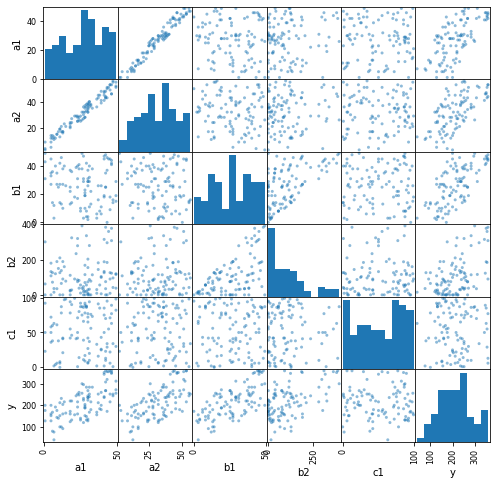

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,0.01635449,0.01635449,0.999997,0.000000e+00,0,,3.95712898,0.03952642,3.99777880,0.00013161,-0.00096098
1,Lasso -0.0001|False,0.01635530,0.01635530,0.999997,0.000000e+00,0,,3.95712790,0.03952718,3.99777831,0.00013166,-0.00096078
2,Lasso -0.001|False,0.01636262,0.01636262,0.999997,0.000000e+00,0,,3.95711815,0.03953400,3.99777385,0.00013213,-0.00095898
3,Lasso -0.01|False,0.01643660,0.01643660,0.999997,0.000000e+00,0,,3.95702070,0.03960217,3.99772932,0.00013680,-0.00094099
4,Lasso -1|False,0.03306021,0.03306021,0.999994,0.000000e+00,1,c1,3.94328428,0.05076720,3.99339469,0.00064320,0.00000000
5,Lasso -5|False,0.21447365,0.21447365,0.999958,0.000000e+00,1,c1,3.87438714,0.11137776,3.97794615,0.00266823,0.00000000
6,Lasso -1e-10|True,0.00054926,0.00054926,1.000000,3.074163e-02,0,,4.00831087,-0.00807910,4.00000045,-0.00000868,0.00007239
7,Lasso -0.0001|True,0.00021749,0.00021749,1.000000,2.081531e-02,1,b2,4.00519299,-0.00498720,3.99990798,0.00000000,0.00001165
8,Lasso -0.001|True,0.00022426,0.00022426,1.000000,4.432050e-02,3,"a2, b2, c1",3.99916097,0.00000000,3.99917078,0.00000000,-0.00000000
9,Lasso -0.01|True,0.02245790,0.02245790,0.999996,4.435279e-01,3,"a2, b2, c1",3.99159882,0.00000000,3.99170663,0.00000000,-0.00000000


In [5]:
pdd = gen_dataset(100)
test_set = addy(pdd,pdd["a1"]*4+4*pdd["b1"]) 
print( test_set.head(10))
pdres = test_batch( test_set )
pdres

Now we add non-linearity to model by a1^2
We can see that models are not able to get a good approximation.

   a1  a2  b1   b2  c1     y
0  34  42  13   65  86  1208
1   6   6   7   21  98    64
2  36  38  36  180  97  1440
3   6   9  23   23  35   128
4  11  20  33  231  69   253
5  40  46  32  288  33  1728
6  30  32   2   10  91   908
7  36  38  25  225  56  1396
8  43  43  23  138  93  1941
9  28  31   4   20  47   800


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62374.90685081575, tolerance: 13808.6718
  positive)


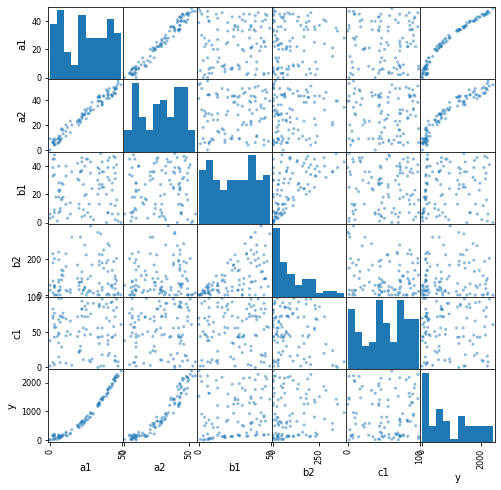

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,35585.78814851,35585.78814851,0.934423,0.000000,0,,63.04209153,-17.64104756,0.82309165,-0.25825732,-1.78703616
1,Lasso -0.0001|False,35585.78814851,35585.78814851,0.934423,0.000000,0,,63.04206470,-17.64102208,0.82309098,-0.25825745,-1.78703678
2,Lasso -0.001|False,35585.78814906,35585.78814906,0.934423,0.000000,0,,63.04182324,-17.64079273,0.82308502,-0.25825864,-1.78704239
3,Lasso -0.01|False,35585.78820348,35585.78820348,0.934423,0.000000,0,,63.03940868,-17.63849938,0.82302540,-0.25827055,-1.78709849
4,Lasso -1|False,35586.33746063,35586.33746063,0.934422,0.000000,0,,62.77390156,-17.38631863,0.81646547,-0.25957938,-1.79326715
5,Lasso -5|False,35599.48723685,35599.48723685,0.934397,0.000000,0,,61.70283585,-16.36899252,0.78993962,-0.26485341,-1.81814349
6,Lasso -1e-10|True,29935.41672274,29935.41672274,0.944835,-241.990258,0,,55.82233523,-8.15948226,3.01553031,-0.20450492,-0.47973894
7,Lasso -0.0001|True,29935.41685288,29935.41685288,0.944835,-242.001910,0,,55.81814474,-8.15539248,3.01546337,-0.20450583,-0.47974697
8,Lasso -0.001|True,29935.42972618,29935.42972618,0.944835,-242.106740,0,,55.78044887,-8.11860220,3.01486038,-0.20451393,-0.47981900
9,Lasso -0.01|True,29936.71771033,29936.71771033,0.944833,-243.155318,0,,55.40336100,-7.75057517,3.00883438,-0.20459590,-0.48054106


In [6]:
pdd = gen_dataset(100)
test_set = addy(pdd,pdd["a1"]**2+4*pdd["b1"]) 
print( test_set.head(10))
pdres = test_batch( test_set )
pdres

Now added some small noise.

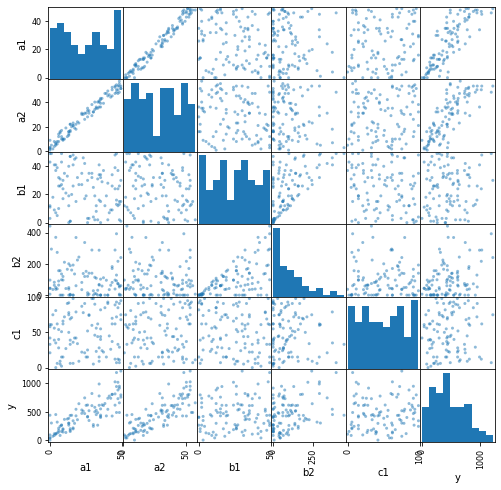

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,10546.98005866,10546.98005866,0.859140,0.000000,0,,16.04614388,-1.14750316,0.10113689,1.09549400,-0.08232779
1,Lasso -0.0001|False,10546.98005866,10546.98005866,0.859140,0.000000,0,,16.04611842,-1.14747983,0.10113482,1.09549419,-0.08232804
2,Lasso -0.001|False,10546.98005918,10546.98005918,0.859140,0.000000,0,,16.04588919,-1.14726978,0.10111610,1.09549589,-0.08233034
3,Lasso -0.01|False,10546.98011120,10546.98011120,0.859140,0.000000,0,,16.04359743,-1.14516985,0.10092901,1.09551291,-0.08235334
4,Lasso -1|False,10547.50545093,10547.50545093,0.859133,0.000000,0,,15.79151326,-0.91418449,0.08034923,1.09738498,-0.08488299
5,Lasso -5|False,10558.09206316,10558.09206316,0.858992,0.000000,0,,14.87647115,-0.07503868,0.00383217,1.10428300,-0.09378187
6,Lasso -1e-10|True,10463.87480789,10463.87480789,0.860250,-32.445707,0,,15.00181846,0.14378877,0.50492650,1.09761706,0.08886149
7,Lasso -0.0001|True,10463.87495179,10463.87495179,0.860250,-32.426663,0,,15.00622486,0.13959025,0.50492853,1.09758791,0.08880246
8,Lasso -0.001|True,10463.88841952,10463.88841952,0.860250,-32.258891,0,,15.04463934,0.10296808,0.50492508,1.09733235,0.08827717
9,Lasso -0.01|True,10463.93255439,10463.93255439,0.860249,-31.678064,0,,15.05308161,0.08870971,0.49831757,1.09682502,0.08483306


In [7]:
pdd3 = gen_dataset(100)
pdres = test_batch( addy(pdd3,pdd3["a1"] * 14 * np.random.uniform(0.5,1.5,100)  + pdd3["b2"]) )
pdres

Now I try non-linear model with Polynomial. 
Now we can see that
a1**2 	1.000000e+00
so model makes a good approximation.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
pdd = gen_dataset(100)
test_set = addy(pdd,pdd["a1"]**2+4*pdd["b1"]) 
predicts,modelo = poly_model(test_set[test_set.columns.drop(["a2","b2","y"])],test_set["y"])
p1 = pd.DataFrame( )
p1["Variable"] = ["1","a1","b1","c1","a1**2","a1*b1","c1*a1","b1**2","b1*c1","c1**2"]
p1["Value"] = modelo.steps[1][1].coef_

p1

,Variable,Value
0,1,0.000000e+00
1,a1,4.019007e-14
2,b1,4.000000e+00
3,c1,6.098420e-15
4,a1**2,1.000000e+00
5,a1*b1,-4.857226e-16
6,c1*a1,8.465451e-16
7,b1**2,4.510281e-16
8,b1*c1,1.804112e-16
9,c1**2,-1.609823e-15
